In [1]:
import pickle
import os
from collections import Iterable
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import copy

sns.set()
plt.rcParams.update({'font.size': 22})

<ipython-input-1-ca8d91b5fe10>:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable


In [2]:
def flatten(lis):
     for item in lis:
        if isinstance(item, Iterable) and not isinstance(item, str):
            for x in flatten(item):
                yield x
        else:        
            yield item
            
def find(lst, s):
    return [i for i, x in enumerate(lst) if x==s]

def keys_exists(element, *keys):
    '''
    Check if *keys (nested) exists in `element` (dict).
    '''
    if not isinstance(element, dict):
        raise AttributeError('keys_exists() expects dict as first argument.')
    if len(keys) == 0:
        raise AttributeError('keys_exists() expects at least two arguments, one given.')

    _element = element
    for key in keys:
        try:
            _element = _element[key]
        except KeyError:
            return False
    return True

In [3]:
def compute_aggreated_results_dict(algorithm, dataset, path='../results', err_metric='mase'):
    results_dict={}
    for file in [path for path in os.listdir(path) if algorithm in path and dataset in path]:
        with open(f'{path}/{file}', 'rb') as handle:
            flatten_file_name = list(flatten([i.split('.') for i in file.split('_')]))
            idx_dataset_name = find(flatten_file_name, dataset)[0]
            sample = flatten_file_name[idx_dataset_name+1:-1][-1]
            version = flatten_file_name[idx_dataset_name+1:-1][-2]
            transformation = '_'.join(flatten_file_name[idx_dataset_name+1:-1][:-2])
            if not keys_exists(results_dict, transformation):
                results_dict[transformation] = {}
            if not keys_exists(results_dict, transformation, version): 
                results_dict[transformation][version] = {}
            if not keys_exists(results_dict, transformation, version, sample):    
                results_dict[transformation][version][sample] = {}
                
            results_dict_temp = copy.deepcopy(results_dict)
            results_dict_temp[transformation][version][sample] = pickle.load(handle)

            results_dict[transformation][version][sample][err_metric] = {}

            # We are getting the results for each group as lists and we want to store it 
            # as objects such as {'mase': {bottom_ind_1: value}, {bottom_ind_2: value}}
            for (k,v_) in results_dict_temp[transformation][version][sample][err_metric].items():
                # if it is the original versions we only want to get the individual results
                if version =='orig':
                    try: 
                        for i in range(len(v_)):
                            results_dict[transformation][version][sample][err_metric][f'{k}_{i}'] = v_[i]
                    except TypeError:
                        # the group has individual results
                        pass
                else:
                    results_dict[transformation][version][sample][err_metric][f'{k}'] = v_
        handle.close()
    return results_dict

In [4]:
def compute_aggregated_results_df(results_dict):
    # shape=(transformation, version, sample, metric, dim)
    # metric = mase, rmse
    # dim = bottom, total, state, gender, legal, all
    
    df = pd.DataFrame.from_dict({(i, j, k, l): results_dict[i][j][k][l]
                           for i in results_dict.keys() 
                           for j in results_dict[i].keys()
                           for k in results_dict[i][j].keys()
                           for l in results_dict[i][j][k].keys()}, orient='index')
    df = df.reset_index()
    df.rename(columns={'level_0':'transformation',
                       'level_1':'version',
                       'level_2':'sample',
                       'level_3':'error',}, inplace=True)
    df = df.melt(id_vars=['transformation', 'version', 'sample', 'error'],
           var_name = 'group',
           value_name = 'value')
    df['group'] = df['group'].str.split('_').str[0]
    df.dropna(inplace=True)
    
    return df

In [5]:
import unittest

class TestModel(unittest.TestCase):
    
    def __init__(self, dataset, algorithm, n_bottom, n_all):
        self.dataset = dataset
        self.algorithm = algorithm
        self.n_bottom = n_bottom
        self.n_all = n_all
        
    def setUp(self):
        dict_res = compute_aggreated_results_dict(algorithm=self.algorithm, 
                                                  dataset=self.dataset)
        self.df_res = compute_aggregated_results_df(dict_res)
        self.df_res = self.df_res[(self.df_res['version']=='orig')
                                  &(self.df_res['error']=='mase')
                                  &(self.df_res['transformation']==f'{self.algorithm}_jitter')]

    def test_results_number_series_bottom(self):
        self.assertEqual(self.df_res.groupby(['group']).count()['value']['bottom'], self.n_bottom)
        
    def test_results_number_series_all(self):
        self.assertEqual(self.df_res.groupby(['group']).count()['value']['all'], self.n_all)

In [6]:
# Run tests

# Prison dataset
t = TestModel('prison', 'mint', 32, 45)
t.setUp()
t.test_results_number_series_bottom()
t.test_results_number_series_all()

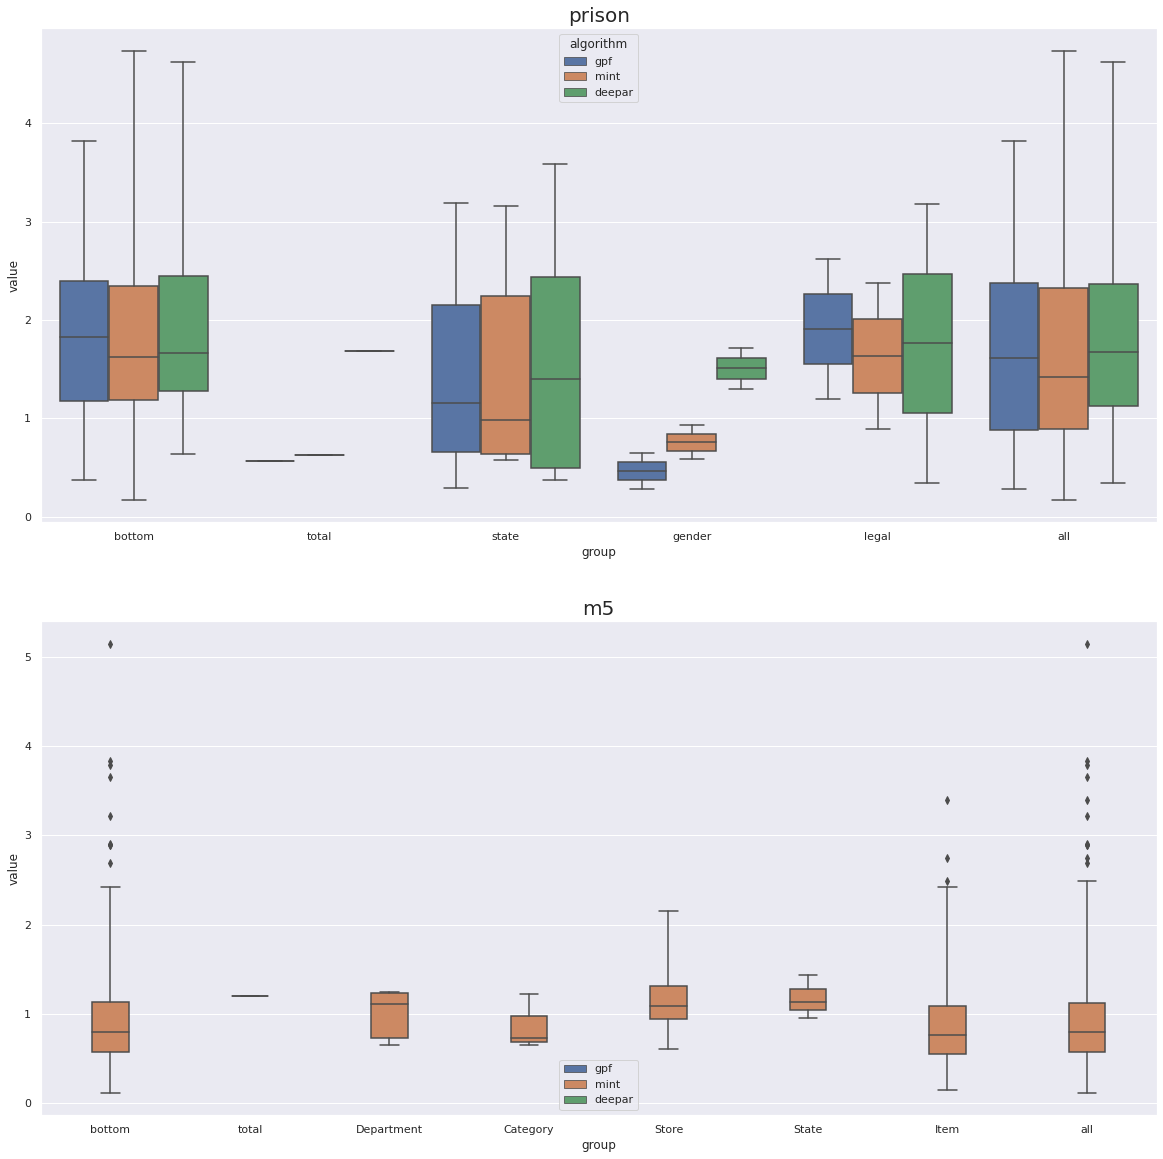

In [13]:
datasets = ['prison', 'm5']
query = 'time_warp'
df_orig_list = []
for d in datasets:
    dict_gpf = compute_aggreated_results_dict(algorithm='gpf', dataset=d)
    df_gpf = compute_aggregated_results_df(dict_gpf)
    dict_mint = compute_aggreated_results_dict(algorithm='mint', dataset=d)
    df_mint = compute_aggregated_results_df(dict_mint)
    dict_deepar = compute_aggreated_results_dict(algorithm='deepar', dataset=d)
    df_deepar = compute_aggregated_results_df(dict_deepar)
    df_gpf['algorithm']='gpf'
    df_mint['algorithm']='mint'
    df_deepar['algorithm']='deepar'
    df = pd.concat([df_gpf, df_mint, df_deepar])
    df_orig = df[(df['version']=='orig')&(df['error']=='mase')].reset_index().drop(['index'], axis=1)
    
    # Usually we run 4 transformations even for the original dataset
    # ensure that we are analysing only one
    df_orig = df_orig[df_orig['transformation'].str.contains(query)]

    # sort values by algorithm to plot gpf -> mint -> deepar
    sorter = ['gpf', 'mint', 'deepar']
    df_orig.algorithm = df_orig.algorithm.astype("category")
    df_orig.algorithm.cat.set_categories(sorter, inplace=True)
    df_orig_list.append(df_orig)

_, ax = plt.subplots(len(datasets), 1, figsize=(20, 10*len(datasets)))
ax = ax.ravel()
for i in range(len(datasets)):
    fg = sns.boxplot(x='group', 
                      y='value',
                      hue='algorithm',
                      data=df_orig_list[i],
                      ax=ax[i])
    ax[i].set_title(datasets[i], fontsize=20)
plt.legend()
plt.show()